In [1]:
import pandas as pd
import numpy as np
import re

import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab

from collections import Counter

from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_pickle('initial_clean.pkl')
df = df[df['violations_orig'].notna()]

results_dict = {'Pass': 0, 'Fail': 1}
df['results_re'] = df['results_re'].str.replace('Pass w/ Conditions', 'Pass')
df['results_re'] = df['results_re'].apply(lambda x: results_dict[x])

In [3]:
# Sort dataframe by inspection date
# Training set will include initial 80% of inspections
sorted_df = df.sort_values(by=['date_orig'])

In [4]:
target_col = ['results_re']
target = sorted_df[target_col]

cols_to_exclude = ['name', 'id_orig', 'id_re', 'license']
feature_cols = [col for col in sorted_df.columns if (col not in cols_to_exclude and col not in target_col)]
features = sorted_df[feature_cols]

In [5]:
# Don't shuffle data before splitting
train_feat, test_feat, train_targ, test_targ = train_test_split(features, target, test_size=0.2,
                                                                shuffle=False)

In [6]:
text_col = ['violations_orig']
train_feat_txt = train_feat[text_col].astype(str)
test_feat_txt = test_feat[text_col].astype(str)

In [7]:
tokenizer = get_tokenizer('basic_english')
counter = Counter()

In [8]:
# Create vocab using training set only
for idx, text in train_feat_txt.itertuples():
    counter.update(tokenizer(text))

In [9]:
MIN_FREQ = 500
vocab = Vocab(counter, min_freq=MIN_FREQ)
len(vocab)

1081

In [10]:
train_cat = pd.concat([train_feat_txt, train_targ], axis=1)
train_cat.shape

(29243, 2)

In [11]:
train_cat['violations_orig'] = train_cat['violations_orig'].str.lower()

In [12]:
failed = train_cat[train_cat['results_re'] == 1]
passed = train_cat[train_cat['results_re'] == 0]

In [13]:
LEN_FAILED = len(failed)
LEN_PASSED = len(passed)

rel_freq = []
for word in vocab.stoi:
    word = str(word)
    try:
        freq_failed = sum(failed['violations_orig'].str.contains(re.escape(word))) / LEN_FAILED
        freq_passed = sum(passed['violations_orig'].str.contains(re.escape(word))) / LEN_PASSED
    except TypeError as e:
        print("Error for word {}: {}".format(word, e))
        continue
    rel_freq.append([word, freq_failed, freq_passed])

In [14]:
freq_df = pd.DataFrame(rel_freq)

In [15]:
freq_df.rename({0: 'word', 1: 'freq_failed', 2: 'freq_passed'}, inplace=True, axis=1)
freq_df.head()

,word,freq_failed,freq_passed
0,<unk>,0.000000,0.000000
1,<pad>,0.000000,0.000000
2,.,1.000000,1.000000
3,",",0.994542,0.992428
4,and,0.993372,0.992916


In [16]:
freq_df['freq_diff'] = freq_df['freq_failed'] - freq_df['freq_passed']

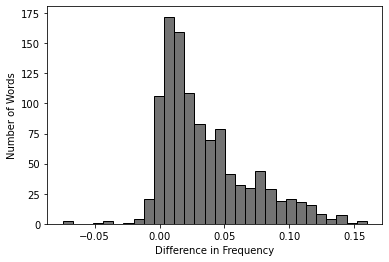

In [17]:
ax = sns.histplot(data=freq_df, x='freq_diff', color='#444444')
ax.set(xlabel='Difference in Frequency', ylabel='Number of Words')
plt.show()

In [18]:
freq_long = pd.melt(freq_df, id_vars='word', value_vars=['freq_failed', 'freq_passed'])
freq_long.head()

,word,variable,value
0,<unk>,freq_failed,0.000000
1,<pad>,freq_failed,0.000000
2,.,freq_failed,1.000000
3,",",freq_failed,0.994542
4,and,freq_failed,0.993372


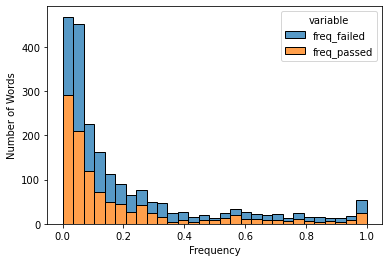

In [19]:
ax = sns.histplot(data=freq_long, x='value', hue='variable', multiple='stack')
ax.set(xlabel='Frequency', ylabel='Number of Words')
plt.show()

In [20]:
sorted_freq = freq_df.sort_values(by='freq_diff')
sorted_freq.head(10)

,word,freq_failed,freq_passed,freq_diff
60,serious,0.631579,0.706275,-0.074696
23,instructed,0.516179,0.589812,-0.073632
117,citation,0.278363,0.322438,-0.044075
40,violation,0.573099,0.613689,-0.040590
114,issued,0.297076,0.336532,-0.039456
903,7,0.791033,0.816665,-0.025632
353,cloths,0.065887,0.084302,-0.018415
485,43,0.082261,0.099445,-0.017184
716,scoop,0.031579,0.046068,-0.014489
327,build-up,0.082261,0.095997,-0.013735


In [21]:
sorted_freq.tail(10)

,word,freq_failed,freq_passed,freq_diff
79,ventilation,0.651072,0.513682,0.137390
668,bin,0.707602,0.569983,0.137620
83,rooms,0.704873,0.566759,0.138114
151,critical,0.411306,0.272922,0.138385
115,control,0.529045,0.389834,0.139211
65,water,0.593372,0.454119,0.139253
116,hot,0.444834,0.305533,0.139302
137,facilities,0.428460,0.282180,0.146280
515,through,0.451072,0.291963,0.159109
693,low,0.619883,0.460154,0.159729
